<a href="https://colab.research.google.com/github/cmunozcortes/home-credit-default-project/blob/main/project_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data exploration


1.   Clean the data and fix any issues you see (missing values?). 
    
    I think we should start working only with `application_train|test.csv`. If by the time we have a functional model there is enough time left, we can take a look at the rest of the data, i.e. `bureau.csv`, `previous_application.csv`, etc.

2.   Look at the relationship between variables


## Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/drive')

# List files in the data dir
os.listdir('drive/MyDrive/CS 249 Project/Data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [ ]:
# Load training data
train_df = pd.read_csv('drive/MyDrive/CS 249 Project/Data/application_train.csv')
print('Training data shape: ', train_df.shape)
train_df.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

Explore the data and address any issues

### Is the data balanced?
Look at the target column and plot its distribution

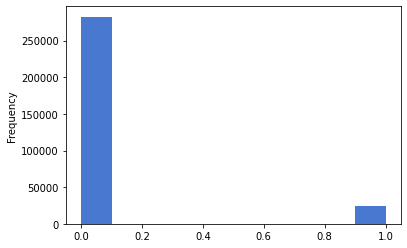

In [ ]:
train_df.TARGET.plot.hist()

Clearly the data isn't balanced. The number of loans that were repaid is far greater than the number of loans that were not repaid. We don't need to address this issue right now though.

### Are there missing values?

In [ ]:
missing_values = train_df.isna().sum()
missing_values_percent = missing_values*100/len(train_df)
miss_df = pd.concat(
    [missing_values.rename('missing_val'), 
     missing_values_percent.rename('missing_val_percent')],
    axis=1
)
miss_df.sort_values(by='missing_val_percent', ascending=False).head(10)

,missing_val,missing_val_percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


## Which features are categorical?

In [ ]:
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [ ]:
categorical_features = train_df.select_dtypes('object')
categorical_features.nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Encode these categorical features. We can either use one-hot encoding (which we've used in the class) or label encoding. One-hot encoding seems to be the preferred method, with the only caveat that if there's a large number of categories for a feature, the number of one-hot encoded features can explode. A workaround is to use PCA or another dimensionality reduction method.

Let's label encode the features with 2 categories and one-hot encode the ones with more than 2.

In [ ]:
# Label encode the features with 2 categories
label_encoder = LabelEncoder()

for feat in categorical_features:
  if len(train_df[feat].unique()) <= 2:
    train_df[feat] = label_encoder.fit_transform(train_df[feat])
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [ ]:
# One-hot encode features with more than 2 categories
train_df = pd.get_dummies(train_df, drop_first=True)
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FONDKAPREMONT_MODE_reg oper spec account',
       'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=230)

## Anomalies
According to the reference notebook, the feature `DAYS_BIRTH` has negative numbers because they are recorded relative to the current loan application. The feature is described as client's age in days at the time of the application.
It's easier to find anomalies if we transform to years.

In [ ]:
# Convert BIRTH_DAYS to years
(train_df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Given the min and the max, there doesn't seem to be any outliers.

Now let's look at DAYS_EMPLOYED. This feature is described as:
>How many days before the application the person started current employment.

In [ ]:
train_df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

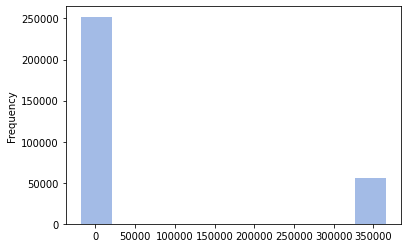

In [ ]:
train_df['DAYS_EMPLOYED'].plot.hist(alpha=0.5)

There's clearly a chunk of samples for this feature that aren't right. It makes no sense for this to be negative and have such a large absolute value. A safe way to deal with this is to set those values to NaN and impute them later.

Before setting all anomalous values to NaN, check to see if the anomalous clients have any patterns of behavior in terms of credit default (higher or lower rates).

In [ ]:
max_days_employed = train_df['DAYS_EMPLOYED'].max()
anom = train_df[train_df['DAYS_EMPLOYED'] == max_days_employed]
non_anom = train_df[train_df['DAYS_EMPLOYED'] != max_days_employed]
print(f'Value of days employed anomaly (aka max of days employed column):', max_days_employed)
print(f'The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print(f'The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print(f'There are %d anomalous days of employment' % len(anom))

Value of days employed anomaly (aka max of days employed column): 365243
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Since the anomalous clients have a lower rate of default, we would like to capture this information in a separate column before clearing the anomalous values. We will fill in the anomalous values with NaN and create a boolean column to indicate whether the value was anomalous or not.

Count of samples with max DAYS_EMPLOYED: 55374


Text(0.5, 0, 'Days employed prior to application')

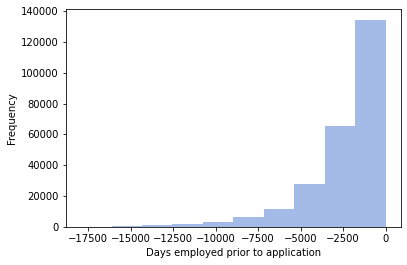

In [ ]:
# Create an anomalous flag column
train_df['DAYS_EMPLOYED_ANOM'] = train_df["DAYS_EMPLOYED"] == max_days_employed

# How many samples have the max value as DAYS_EMPLOYED?
max_value_count = (train_df['DAYS_EMPLOYED'] == train_df['DAYS_EMPLOYED'].max()).sum()
print(f"Count of samples with max DAYS_EMPLOYED: {max_value_count}")

# Replace all these occurrences with NaN
train_df.DAYS_EMPLOYED.replace(
    to_replace=train_df.DAYS_EMPLOYED.max(),
    value=np.nan,
    inplace=True)

train_df.DAYS_EMPLOYED.plot.hist(alpha=0.5)
plt.xlabel('Days employed prior to application')

In [ ]:
print('There are %d anomalies in the train data out of %d entries' % (train_df["DAYS_EMPLOYED_ANOM"].sum(), len(train_df)))

There are 55374 anomalies in the train data out of 307511 entries


## Impute Missing Data

If more than 48% of a column's data is missing, the column will be entirely removed from the dataset. If less than 50% of a column's data is missing, the missing data will be imputed using various methods (mean, median, or mode imputation)

In [ ]:
missing_values = train_df.isna().sum()
missing_values_percent = missing_values*100/len(train_df)
miss_df = pd.concat(
    [missing_values.rename('missing_val'), 
     missing_values_percent.rename('missing_val_percent')],
    axis=1
)
miss_df.sort_values(by='missing_val_percent', ascending=False).head(10)

,missing_val,missing_val_percent
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630


In [ ]:
print(f"Training data shape before dropping columns:", train_df.shape)

# get columns missing >= 48% of the information
missing_48pct = miss_df.loc[miss_df['missing_val_percent'] >= 48]
missing_48pct_rows = missing_48pct.index.values

print(f"Number of columns missing 48% or more of the data:", len(missing_48pct_rows))

for row in missing_48pct_rows:
  train_df = train_df.drop(row, axis=1)

print(f"Training data shape after dropping columns:", train_df.shape)

Training data shape before dropping columns: (307511, 231)
Number of columns missing 48% or more of the data: 45
Training data shape after dropping columns: (307511, 186)


In [ ]:
missing_values = train_df.isna().sum()
missing_values_percent = missing_values*100/len(train_df)
miss_df = pd.concat(
    [missing_values.rename('missing_val'), 
     missing_values_percent.rename('missing_val_percent')],
    axis=1
)
print(f"Missing values data shape:", missing_values.shape)
miss_df.sort_values(by='missing_val_percent', ascending=False).head(20)

Missing values data shape: (186,)


,missing_val,missing_val_percent
EXT_SOURCE_3,60965,19.825307
DAYS_EMPLOYED,55374,18.007161
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.332021
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.332021


## Relationships between variables
With `.corr` method we can use the Pearson correlation coefficient to find relationships between the features in the training set.

In [ ]:
corr_matrix = train_df.corr().TARGET.sort_values()

print(f'Highest positive correlations:\n {corr_matrix.tail(10)}\n')
print(f'Highest negative correlations:\n {corr_matrix.head(10)}')

Highest positive correlations:
 REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Highest negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
AMT_GOODS_PRICE                        -0.039645
Name: TARGET, dt

### Features with highest positive correlation: Effect of age on repayment

The feature with highest positive correlation is `DAYS_BIRTH`. Let's look at it in more datail.
Positive correlation means that as `DAYS_BIRTH` increases the customer is less likely to repay the loan. However, this `DAYS_BIRTH` is given as negative numbers, it's easier to understand its relationship to `TARGET` if we multiply by -1.

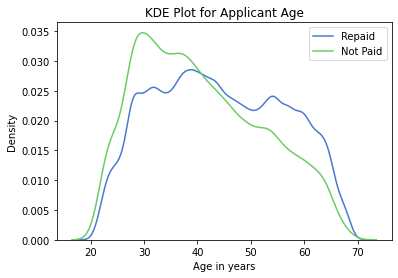

In [ ]:
plt.style.use('seaborn-muted')

# Make DAYS_BIRTH positive
train_df.DAYS_BIRTH = train_df.DAYS_BIRTH * -1

# Plot the distribution of ages in years
sns.kdeplot(train_df.loc[train_df.TARGET == 0, 'DAYS_BIRTH'] / 365)
sns.kdeplot(train_df.loc[train_df.TARGET == 1, 'DAYS_BIRTH'] / 365)

plt.xlabel('Age in years')
plt.title('KDE Plot for Applicant Age')
plt.legend(['Repaid', 'Not Paid'])

From the plot it looks like among the pool of applicants who were not able to repay their loan, the majority of them were younger than 30 years old.

### Features with highest negative correlation
The three features with highest negative correlation are `EXT_SOURCE_3`, `EXT_SOURCE_2`, `EXT_SOURCE_1`. These are described as *Normalized score from external data source*. 

Let's look at a heat map of their correlation with `TARGET`.

In [ ]:
features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']
ext_corr = train_df[features].corr()
ext_corr

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,TARGET
EXT_SOURCE_1,1.000000,0.213982,0.186846,0.600610,-0.155317
EXT_SOURCE_2,0.213982,1.000000,0.109167,0.091996,-0.160472
EXT_SOURCE_3,0.186846,0.109167,1.000000,0.205478,-0.178919
DAYS_BIRTH,0.600610,0.091996,0.205478,1.000000,-0.078239
TARGET,-0.155317,-0.160472,-0.178919,-0.078239,1.000000


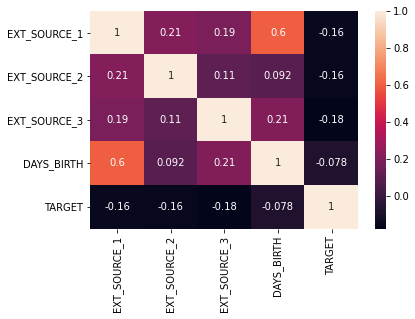

In [ ]:
sns.heatmap(ext_corr, annot=True)

The correlation matrix tells us that as the value of the external source features increases, the customer is more likely to repay the loan. Similarly, as the age of the customer increases, the higher the chance of the loan to be repaid.

## Feature Engineering

### Polynomial features


In [ ]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import PolynomialFeatures

# Make new df with polynomial features
poly_features = train_df[features]

# Assign variables
y = poly_features.TARGET
X = poly_features.drop(columns='TARGET')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Create polynomial features
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)
poly.get_feature_names(features[:-1])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']